create algorithm to detect that greater frequency of purchase indicates a more latest purchase

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df_oct = pd.read_csv("data/vumonic_india_food_delivery_20231001_20231031.csv", low_memory=False)
df_nov = pd.read_csv("data/vumonic_india_food_delivery_20231101_20231130.csv", low_memory=False)

# with open('data/vumonic_india_food_delivery_20231201_20231231.csv', 'r') as f:
#     first_line = f.readline()
# columns = first_line.replace('\n', '').split(',')
columns = df_nov.columns

df_dec = pd.read_csv('data/vumonic_india_food_delivery_20231201_20231231.csv', usecols=columns, encoding='latin-1', low_memory=False)

df = pd.concat([df_dec, df_nov, df_oct], ignore_index=True)
drop_columns = ['mid', 'sender_id', 'year', 'month', 'day', 'order_promotion_discount', 
                'order_coupon_discount', 'order_seller_discount', 'order_delivery_discount',
                'order_status', 'order_delivery_discount', 'delivery_address_postal_code', 'order_payment_currency',
                'restaurant_address_postal_code', 'user_dob', 'user_address_postal_code', 'user_address_country']
df =  df.drop(drop_columns, axis=1)
df = df[df['user_age'] != 'male']

In [3]:
df.head()

,transaction_id,company,email_timestamp,product_name,product_price,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,order_discount_code,premium_membership,premium_membership_type,free_delivery,order_payment_type,delivery_address_city,delivery_address_state,restaurant_name,restaurant_address_city,restaurant_address_state,user_id,user_gender,user_age,user_address_city,user_address_state,user_device_brand,user_device_model,user_os_type,user_onboard_at,user_inactive_at
0,bfa86dc42518cc98cb1f6a5dc3ac6a5d,swiggy,2023-12-01T00:08:24+00:00,Classic Chicken Roll,216.0,1.0,216.0,216.0,3.0,7.0,NaN,NaN,7.69,NaN,100.00,NaN,134.0,SWIGGYIT,True,swiggy_one,NaN,paytm,bangalore,karnataka,Rollsking,bangalore,karnataka,edb4a1a7320232810d47fdf695fdbeb1,male,23.0,Bengaluru,Karnataka,samsung,SM-G781B,android,2023-07-10T11:03:52.000Z,NaN
1,bfa86dc42518cc98cb1f6a5dc3ac6a5d,swiggy,2023-12-01T00:08:24+00:00,Multigrain Laccha Paratha Roll,NaN,NaN,NaN,216.0,3.0,7.0,NaN,NaN,7.69,NaN,100.00,NaN,134.0,SWIGGYIT,True,swiggy_one,Free,paytm,bangalore,karnataka,Rollsking,bangalore,karnataka,edb4a1a7320232810d47fdf695fdbeb1,male,23.0,Bengaluru,Karnataka,samsung,SM-G781B,android,2023-07-10T11:03:52.000Z,NaN
2,614f8a99775ff921f7360f4140a7ba11,swiggy,2023-12-01T00:10:41+00:00,Double Cheese Slice,NaN,NaN,NaN,256.0,3.0,10.0,NaN,NaN,8.84,NaN,99.99,NaN,178.0,FLATDEAL,True,swiggy_one,Free,bank,hyderabad,telangana,Shrimmers,hyderabad,telangana,a13bf807ac3741ae6d118472115fef00,male,28.0,Hyderabad,Telangana,realme,RMX3395,android,2023-05-02T22:38:13.000Z,NaN
3,614f8a99775ff921f7360f4140a7ba11,swiggy,2023-12-01T00:10:41+00:00,Crispy Potato Burger,89.0,1.0,89.0,256.0,3.0,10.0,NaN,NaN,8.84,NaN,99.99,NaN,178.0,FLATDEAL,True,swiggy_one,NaN,bank,hyderabad,telangana,Shrimmers,hyderabad,telangana,a13bf807ac3741ae6d118472115fef00,male,28.0,Hyderabad,Telangana,realme,RMX3395,android,2023-05-02T22:38:13.000Z,NaN
4,614f8a99775ff921f7360f4140a7ba11,swiggy,2023-12-01T00:10:41+00:00,Cheese Slice,NaN,NaN,NaN,256.0,3.0,10.0,NaN,NaN,8.84,NaN,99.99,NaN,178.0,FLATDEAL,True,swiggy_one,Free,bank,hyderabad,telangana,Shrimmers,hyderabad,telangana,a13bf807ac3741ae6d118472115fef00,male,28.0,Hyderabad,Telangana,realme,RMX3395,android,2023-05-02T22:38:13.000Z,NaN


In [4]:
dj = df

In [5]:
dj = df
for i in dj:
    try:
        dj[i] = dj[i].astype('float')
    except ValueError:
        dj[i] = pd.Categorical(pd.factorize(dj[i])[0]).astype('float')
dj

,transaction_id,company,email_timestamp,product_name,product_price,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,order_discount_code,premium_membership,premium_membership_type,free_delivery,order_payment_type,delivery_address_city,delivery_address_state,restaurant_name,restaurant_address_city,restaurant_address_state,user_id,user_gender,user_age,user_address_city,user_address_state,user_device_brand,user_device_model,user_os_type,user_onboard_at,user_inactive_at
0,0.0,0.0,0.0,0.0,216.0,1.0,216.0,216.0,3.0,7.0,NaN,NaN,7.69,NaN,100.00,NaN,134.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,1.0,NaN,NaN,NaN,216.0,3.0,7.0,NaN,NaN,7.69,NaN,100.00,NaN,134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,1.0,0.0,1.0,2.0,NaN,NaN,NaN,256.0,3.0,10.0,NaN,NaN,8.84,NaN,99.99,NaN,178.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,28.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0
3,1.0,0.0,1.0,3.0,89.0,1.0,89.0,256.0,3.0,10.0,NaN,NaN,8.84,NaN,99.99,NaN,178.0,1.0,1.0,0.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,28.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0
4,1.0,0.0,1.0,4.0,NaN,NaN,NaN,256.0,3.0,10.0,NaN,NaN,8.84,NaN,99.99,NaN,178.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,28.0,1.0,1.0,1.0,1.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741079,394054.0,0.0,379333.0,43838.0,200.0,1.0,200.0,330.0,3.0,20.0,9.0,NaN,13.35,NaN,124.99,NaN,250.0,123.0,NaN,-1.0,-1.0,-1.0,222.0,8.0,2775.0,-1.0,8.0,5281.0,0.0,28.0,1.0,1.0,0.0,426.0,0.0,5279.0,-1.0
741080,394055.0,0.0,379334.0,98261.0,250.0,1.0,250.0,250.0,3.0,NaN,9.0,NaN,8.35,NaN,125.00,NaN,145.0,20.0,NaN,-1.0,-1.0,-1.0,222.0,8.0,2775.0,-1.0,8.0,5281.0,0.0,28.0,1.0,1.0,0.0,426.0,0.0,5279.0,-1.0
741081,394056.0,0.0,379335.0,369.0,320.0,1.0,320.0,320.0,3.0,12.0,9.0,NaN,14.64,NaN,50.00,NaN,309.0,0.0,NaN,-1.0,-1.0,-1.0,222.0,8.0,3950.0,-1.0,8.0,5281.0,0.0,28.0,1.0,1.0,0.0,426.0,0.0,5279.0,-1.0
741082,394057.0,0.0,379336.0,134542.0,109.0,3.0,327.0,327.0,NaN,NaN,NaN,NaN,10.79,NaN,40.00,NaN,187.0,0.0,NaN,-1.0,-1.0,-1.0,26.0,14.0,3543.0,20.0,14.0,7847.0,0.0,22.0,24.0,14.0,14.0,405.0,0.0,7845.0,-1.0


In [6]:
type(dj.company[0])

numpy.float64

In [7]:
dj.corr()

,transaction_id,company,email_timestamp,product_name,product_price,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,order_discount_code,premium_membership,premium_membership_type,free_delivery,order_payment_type,delivery_address_city,delivery_address_state,restaurant_name,restaurant_address_city,restaurant_address_state,user_id,user_gender,user_age,user_address_city,user_address_state,user_device_brand,user_device_model,user_os_type,user_onboard_at,user_inactive_at
transaction_id,1.000000,0.072011,0.996256,0.279526,-0.022133,0.000895,-0.021036,-0.027752,-0.008203,-0.028270,-0.001788,0.003141,-0.027873,-0.029940,-0.016187,-0.009151,-0.016079,0.089220,NaN,-0.093932,-0.028895,-0.187820,-0.112770,-0.173718,0.183695,0.012617,0.020389,0.252297,-0.003934,-0.003037,0.017538,0.010609,0.005039,0.008990,-0.001690,0.252279,0.082404
company,0.072011,1.000000,0.068525,0.076678,NaN,0.001952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034776,-0.214761,NaN,-0.572752,-0.295556,-0.643283,-0.128177,-0.328228,0.234960,0.115343,0.057582,0.450866,-0.034143,0.004653,0.062636,0.010495,0.006821,0.050265,0.003703,0.450817,0.002396
email_timestamp,0.996256,0.068525,1.000000,0.278844,-0.022270,0.001007,-0.021089,-0.027690,-0.008292,-0.028175,-0.001611,0.003361,-0.027322,-0.028904,-0.016075,-0.009076,-0.016365,0.088840,NaN,-0.091403,-0.028042,-0.184019,-0.113899,-0.174448,0.182448,0.012080,0.019847,0.249890,-0.003922,-0.002843,0.017374,0.010464,0.005072,0.008864,-0.001334,0.249871,0.081976
product_name,0.279526,0.076678,0.278844,1.000000,0.078430,-0.052227,0.055589,0.017616,-0.088509,-0.012791,0.024959,0.004475,0.017563,-0.024755,0.032728,0.044085,0.022956,0.016731,NaN,-0.046689,-0.103764,-0.086377,-0.035021,-0.065055,0.200482,0.003958,0.018256,0.096670,0.003174,0.033055,0.012884,0.022562,0.000993,0.007022,-0.003328,0.096594,0.025843
product_price,-0.022133,NaN,-0.022270,0.078430,1.000000,-0.222583,0.822064,0.370616,-0.014144,0.140307,0.112212,0.010250,0.339431,0.101919,0.233991,0.218192,0.346721,0.043169,NaN,0.024301,NaN,0.002152,-0.063807,-0.036018,-0.076332,-0.060640,-0.036018,-0.019784,0.002588,0.019501,-0.012515,-0.041900,-0.012048,-0.032545,0.023300,-0.019863,-0.002340
product_quantity,0.000895,0.001952,0.001007,-0.052227,-0.222583,1.000000,0.120885,0.095742,-0.010990,0.053610,0.007488,0.029860,0.068961,-0.036725,0.051431,0.121956,0.103019,0.007211,NaN,-0.011541,-0.019022,0.002420,0.018840,0.028422,0.049520,0.023982,0.044048,0.019690,-0.016005,0.025425,0.004372,0.031049,0.001872,0.010412,-0.000661,0.019744,-0.003070
product_total,-0.021036,NaN,-0.021089,0.055589,0.822064,0.120885,1.000000,0.491117,-0.012158,0.212455,0.120702,0.033658,0.429654,0.082034,0.293073,0.380176,0.465580,0.040123,NaN,0.010810,NaN,0.003009,-0.053723,-0.020997,-0.059408,-0.050171,-0.020997,-0.006502,0.000378,0.042345,-0.009432,-0.031021,-0.012408,-0.025431,0.024338,-0.006516,-0.003202
order_subtotal,-0.027752,NaN,-0.027690,0.017616,0.370616,0.095742,0.491117,1.000000,0.040244,0.490117,0.199217,0.102908,0.836664,0.138588,0.489663,0.905871,0.970875,0.040723,NaN,0.000171,0.029264,-0.000830,-0.065425,-0.035375,-0.044290,-0.055467,-0.035375,-0.036579,0.021914,0.110712,-0.029075,-0.052116,-0.033783,-0.049486,0.031301,-0.036567,0.004613
order_convenience_fee,-0.008203,NaN,-0.008292,-0.088509,-0.014144,-0.010990,-0.012158,0.040244,1.000000,-0.010229,0.084423,-0.017431,0.035146,-0.032714,-0.025422,0.006172,0.052352,-0.025554,NaN,-0.157878,-0.049554,-0.001666,-0.002407,-0.006488,-0.095616,-0.002846,-0.006488,0.020088,0.014487,-0.020718,-0.006487,-0.012268,0.002674,-0.003247,0.010750,0.020157,0.003509
order_packaging_fee,-0.028270,NaN,-0.028175,-0.012791,0.140307,0.053610,0.212455,0.490117,-0.010229,1.000000,0.119861,0.043361,0.434453,0.080900,0.167148,0.477027,0.519807,-0.028181,NaN,0.001319,-0.005223,0.003012,-0.062559,-0.043105,-0.

<AxesSubplot:>

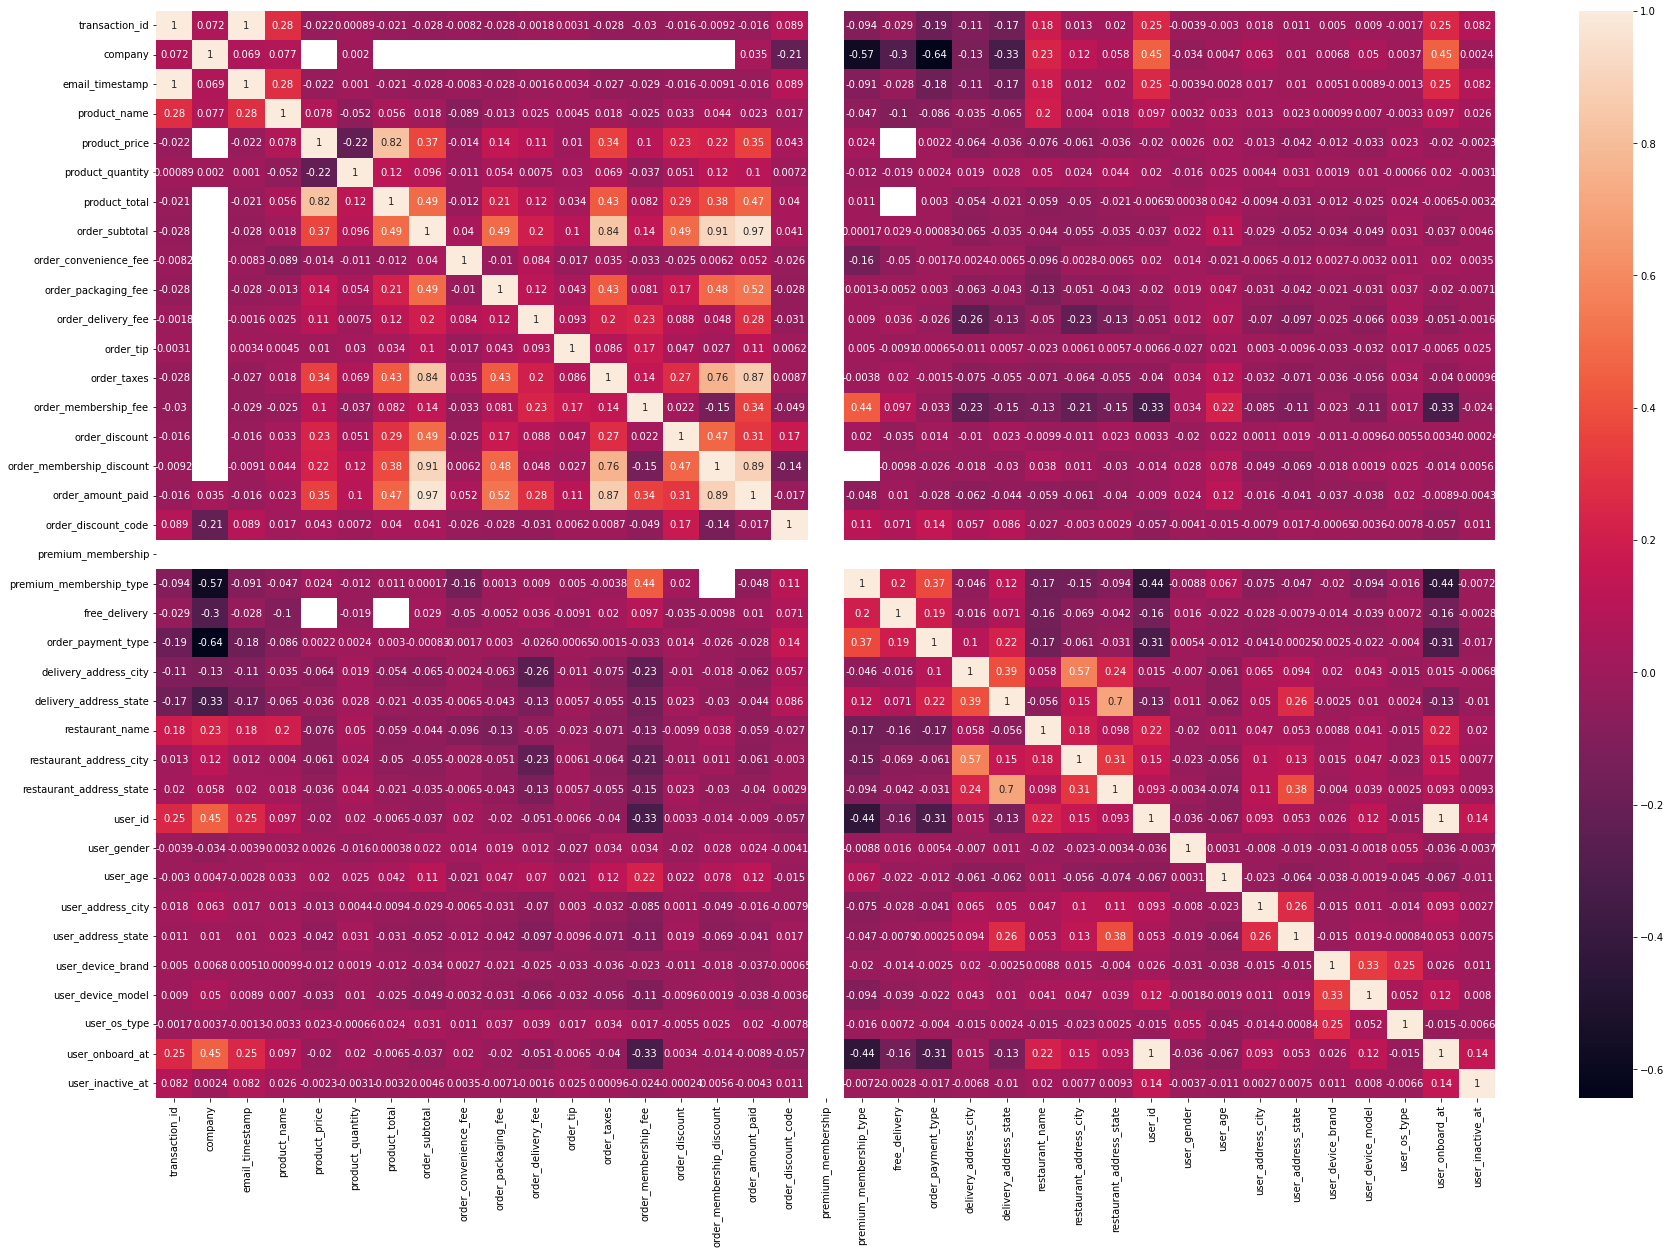

In [8]:
plt.figure(figsize = (30, 20))
sns.heatmap(dj.corr(), annot = True)

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df_oct = pd.read_csv("data/vumonic_india_food_delivery_20231001_20231031.csv", low_memory=False)
df_nov = pd.read_csv("data/vumonic_india_food_delivery_20231101_20231130.csv", low_memory=False)

# with open('data/vumonic_india_food_delivery_20231201_20231231.csv', 'r') as f:
#     first_line = f.readline()
# columns = first_line.replace('\n', '').split(',')
columns = df_nov.columns

df_dec = pd.read_csv('data/vumonic_india_food_delivery_20231201_20231231.csv', usecols=columns, encoding='latin-1', low_memory=False)

df = pd.concat([df_dec, df_nov, df_oct], ignore_index=True)
drop_columns = ['mid', 'sender_id', 'year', 'month', 'day', 'order_promotion_discount', 
                'order_coupon_discount', 'order_seller_discount', 'order_delivery_discount',
                'order_status', 'order_delivery_discount', 'delivery_address_postal_code', 'order_payment_currency',
                'restaurant_address_postal_code', 'user_dob', 'user_address_postal_code', 'user_address_country']
df =  df.drop(drop_columns, axis=1)
df = df[df['user_age'] != 'male']

In [11]:
xx = df[df.user_id == df.user_id[7]]
em = pd.to_datetime(xx.email_timestamp)
min_timestamp = em.min()
max_timestamp = em.max()

# Calculate the total time span
total_time_span = max_timestamp - min_timestamp

# Calculate the number of rows in the column
num_rows = len(em)

# Calculate the average frequency
average_frequency = total_time_span.total_seconds() / (num_rows - 1)  # Subtract 1 because there are (num_rows - 1) intervals between num_rows timestamps

print("Average frequency of timestamps:", average_frequency)

last_date = pd.to_datetime('2023-12-31 23:59:59+0000')
last_diff = (last_date - max_timestamp).total_seconds()

print("Last purchse difference to last possible datetime", last_diff)

Average frequency of timestamps: 95211.09836065574
Last purchse difference to last possible datetime 1741513.0


In [12]:
dfc = df[['user_id', 'email_timestamp']].groupby('user_id')
for i in dfc:
    print(i[1])
    break

                                 user_id            email_timestamp
132954  00017cbcbfdc8cc48d371dd32113eafc  2023-12-26T19:59:40+00:00
141457  00017cbcbfdc8cc48d371dd32113eafc  2023-12-11T20:36:05+00:00
141458  00017cbcbfdc8cc48d371dd32113eafc  2023-12-11T20:36:05+00:00
173864  00017cbcbfdc8cc48d371dd32113eafc  2023-12-21T15:00:12+00:00
192514  00017cbcbfdc8cc48d371dd32113eafc  2023-12-26T21:24:33+00:00
196904  00017cbcbfdc8cc48d371dd32113eafc  2023-12-28T17:41:07+00:00
197196  00017cbcbfdc8cc48d371dd32113eafc  2023-12-18T18:45:06+00:00
197197  00017cbcbfdc8cc48d371dd32113eafc  2023-12-18T18:45:06+00:00
197198  00017cbcbfdc8cc48d371dd32113eafc  2023-12-18T18:45:06+00:00
199453  00017cbcbfdc8cc48d371dd32113eafc  2023-12-12T20:33:25+00:00
224568  00017cbcbfdc8cc48d371dd32113eafc  2023-12-16T17:18:10+00:00
224569  00017cbcbfdc8cc48d371dd32113eafc  2023-12-16T17:18:10+00:00
224570  00017cbcbfdc8cc48d371dd32113eafc  2023-12-16T17:18:10+00:00
371605  00017cbcbfdc8cc48d371dd32113eafc  2023-1

In [13]:
dfc = df[['user_id', 'email_timestamp']].groupby('user_id')

frq, last = [], []
last_date = pd.to_datetime('2023-12-31 23:59:59+0000')

for u in tqdm(dfc):
    xx = u[1]
    
    em = pd.to_datetime(xx.email_timestamp)

    num_rows = len(em)
    
    if num_rows > 10:
        min_timestamp = em.min()
        max_timestamp = em.max()

        # Calculate the total time span
        total_time_span = max_timestamp - min_timestamp

        # Calculate the average frequency
        average_frequency = total_time_span.total_seconds() / (num_rows - 1)  # Subtract 1 because there are (num_rows - 1) intervals between num_rows timestamps

        frq.append(average_frequency)

        last_diff = (last_date - max_timestamp).total_seconds()

        last.append(last_diff)

100%|████████████████████████████████████| 48084/48084 [00:12<00:00, 3856.20it/s]


In [14]:
x = frq
y = last

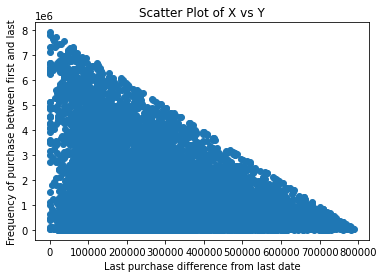

In [15]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the names of the columns for the x and y variables
plt.scatter(x, y)
plt.xlabel('Last purchase difference from last date')
plt.ylabel('Frequency of purchase between first and last')
plt.title('Scatter Plot of X vs Y')
plt.show()


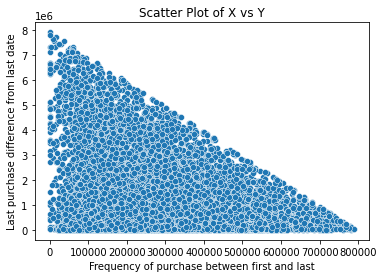

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'x_column' and 'y_column' are the names of the columns for the x and y variables
sns.scatterplot(x=x, y=y)
plt.ylabel('Last purchase difference from last date')
plt.xlabel('Frequency of purchase between first and last')
plt.title('Scatter Plot of X vs Y')
plt.show()


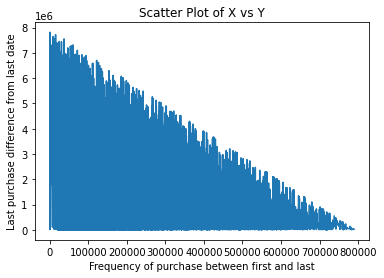

In [17]:
sns.lineplot(x=x, y=y)
plt.ylabel('Last purchase difference from last date')
plt.xlabel('Frequency of purchase between first and last')
plt.title('Scatter Plot of X vs Y')
plt.show()

<AxesSubplot:ylabel='Count'>

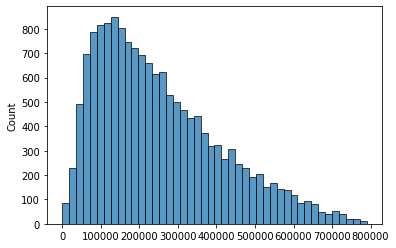

In [18]:
sns.histplot(x)

<AxesSubplot:ylabel='Count'>

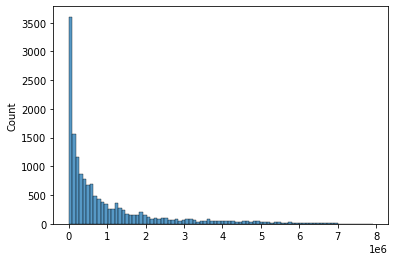

In [19]:
sns.histplot(y)

In [20]:
# from sklearn.linear_model import LinearRegression

# x = np.array(frq).reshape(-1, 1)
# y = np.array(last).reshape(-1, 1)

# regr = LinearRegression()
 
# regr.fit(x, y)

In [21]:

# import statsmodel for linear regression
import statsmodels.api as sm

# Adding a constant to get an intercept
x_sm = sm.add_constant(x)

# Fitting the regression line using 'OLS'
lr = sm.OLS(y, x_sm).fit()

# Parameters
lr.params

array([ 1.23479982e+06, -1.01305925e+00])

In [22]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     235.2
Date:                Sat, 09 Mar 2024   Prob (F-statistic):           1.06e-52
Time:                        18:25:29   Log-Likelihood:            -2.4343e+05
No. Observations:               15690   AIC:                         4.869e+05
Df Residuals:                   15688   BIC:                         4.869e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.235e+06   1.97e+04     62.613      0.000     1.2e+06    1.27e+06
x1            -1.0131      0.066    -15.336      0.000      -1.143      -0.884
==============================================================================
Omnibus:                     5765.495   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18405.709
Skew:                           1.928   Prob(JB):                         0.00
Kurtosis:                       6.646   Cond. No.                     5.57e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The relationship between frequency of purchase and last purchase difference is statistically significant.

In [23]:
type(x[0])

float

In [24]:
float(1.235e+06)

1235000.0

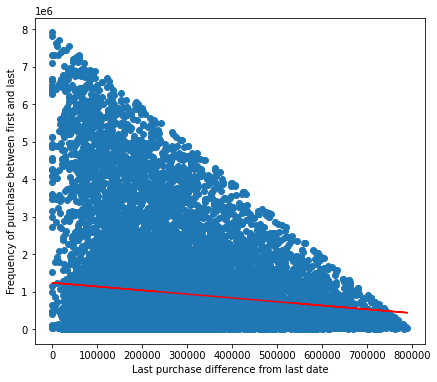

In [25]:
plt.scatter(x, y)
plt.gcf().set_size_inches((7, 6))
plt.plot(pd.Series(x), float(1.235e+06) + (-1.0131) * pd.Series(x), 'r')
plt.xlabel('Last purchase difference from last date')
plt.ylabel('Frequency of purchase between first and last')
plt.show()

next

Payments

In [26]:
dfp = df

In [27]:
dfp['order_payment_type'].value_counts(normalize=True).head(5) * 100

bank                49.230491
creditdebit_card    21.024347
cash                14.106660
lazypay              4.702603
cred                 3.230187
Name: order_payment_type, dtype: float64

In [28]:
for i, age in enumerate(dfp['user_age']):
    try:
        float(age)
    except ValueError:
        dfp = dfp.drop(i)
        print('-', end=' ')

dfp.user_age = dfp.user_age.astype('float')

In [29]:
dfp.user_age.max()

70.0

In [30]:
# ['mid', 'sender_id', 'year', 'month', 'day', 'order_promotion_discount', 'order_coupon_discount', 'order_seller_discount', 'order_delivery_discount', 'order_status' 'order_delivery_discount', 'delivery_address_postal_code', 'restaurant_address_postal_code', 'user_dob', 'user_address_postal_code', 'user_address_country']

In [31]:
bin_size = 5

# Get min and max age from DataFrame
min_age = int(dfp.user_age.min())
max_age = int(dfp.user_age.max())

# Calculate number of bins based on min and max age, with a bin size of 5
num_bins = ((max_age - min_age) // bin_size) + 1

# Create bins and labels lists
bins = [min_age + 5 * i for i in range(num_bins)]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)] + [f'{bins[-1]}+']

bins = bins + [bins[-1] + bin_size]

print("Bins:", bins)
print("Labels:", labels)

Bins: [14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74]
Labels: ['14-19', '19-24', '24-29', '29-34', '34-39', '39-44', '44-49', '49-54', '54-59', '59-64', '64-69', '69+']


In [32]:
# dfp

In [33]:
dfp["user_age_category"] = pd.cut(dfp['user_age'].values.tolist(), bins=bins, labels=labels)
dfp[['user_age', 'user_age_category']]


,user_age,user_age_category
0,23.0,19-24
1,23.0,19-24
2,28.0,24-29
3,28.0,24-29
4,28.0,24-29
...,...,...
741079,28.0,24-29
741080,28.0,24-29
741081,28.0,24-29
741082,22.0,19-24


In [34]:
dfp[['order_payment_type', 'user_age_category']].value_counts()

order_payment_type               user_age_category
bank                             19-24                52003
                                 24-29                47069
                                 29-34                30038
cash                             19-24                20556
creditdebit_card                 24-29                19992
                                                      ...  
swiggy_money                     49-54                    2
simpl                            64-69                    1
swiggy_money | creditdebit_card  54-59                    1
swiggy_money                     54-59                    1
swiggy_money | lazypay           39-44                    1
Length: 177, dtype: int64

In [35]:
dfp.groupby('order_payment_type', group_keys=True)[['order_payment_type']].apply(lambda x: x).value_counts()

order_payment_type             
bank                               171489
creditdebit_card                    73236
cash                                49139
lazypay                             16381
cred                                11252
paytm                                9004
amazonpay                            7556
simpl                                2578
swiggy_money                         2508
mobikwik                             1867
paytm_postpaid                       1048
swiggy_money | bank                   677
phonepe                               583
swiggy_money | creditdebit_card       409
swiggy_money | cash                   218
swiggy_money | amazonpay              155
swiggy_money | cred                   115
swiggy_money | lazypay                 50
swiggy_money | paytm                   38
swiggy_money | mobikwik                23
swiggy_money | paytm_postpaid           5
swiggy_money | phonepe                  5
swiggy_money | paid_via                 3
dt

In [36]:
dfp.order_discount_code.value_counts().reset_index()

,index,order_discount_code
0,SWIGGYIT,71249
1,TRYNEW,44300
2,MISSEDYOU,19710
3,WORLDCUPMANIA,13902
4,FLATDEAL,12279
...,...,...
1545,SWIGGYLOVE-GVVZGC,1
1546,SWIGGYLOVE-NLKOSX,1
1547,SWIGGYLOVE-UBYEZN,1
1548,SWIGGYLOVE-BXLEWW,1


In [37]:
df.order_membership_discount.sort_values(ascending=False)

288043    1204.48
288045    1204.48
288044    1204.48
288042    1204.48
288041    1204.48
           ...   
741079        NaN
741080        NaN
741081        NaN
741082        NaN
741083        NaN
Name: order_membership_discount, Length: 741082, dtype: float64

In [38]:
dfc = df.groupby('user_id')

In [39]:
dfp[dfp.order_amount_paid.isna()]

,transaction_id,company,email_timestamp,product_name,product_price,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,order_discount_code,premium_membership,premium_membership_type,free_delivery,order_payment_type,delivery_address_city,delivery_address_state,restaurant_name,restaurant_address_city,restaurant_address_state,user_id,user_gender,user_age,user_address_city,user_address_state,user_device_brand,user_device_model,user_os_type,user_onboard_at,user_inactive_at,user_age_category
204087,3903ad24a0502012ee9a22f0e3b27c34,zomato,2023-12-18T11:02:08+00:00,Bhujia Sev 1 Kg,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mumbai,maharashtra,Haldirams Sweets and Namkeen,mumbai,maharashtra,179c4ec0bf34846096203ada52c88878,male,25.0,Mumbai,Maharashtra,samsung,SM-M205F,android,2019-12-12T07:25:02.000Z,NaN,24-29
204088,3903ad24a0502012ee9a22f0e3b27c34,zomato,2023-12-18T11:02:08+00:00,Yellow Banana 80 Gm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mumbai,maharashtra,Haldirams Sweets and Namkeen,mumbai,maharashtra,179c4ec0bf34846096203ada52c88878,male,25.0,Mumbai,Maharashtra,samsung,SM-M205F,android,2019-12-12T07:25:02.000Z,NaN,24-29
231493,d708125e4ca6c24d0a5e2e6a2d7da630,zomato,2023-12-22T13:47:36+00:00,Peri Peri chicken strips - 6 Pc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chennai,tamil nadu,KFC,chennai,tamil nadu,8fe2668cc3901691e02ce912d713fb0a,male,32.0,Chennai,Tamil Nadu,samsung,SM-A226B,android,2023-06-23T06:57:01.000Z,NaN,29-34
478127,5a2ed66bf6a8b2a0ff3ec61f68659023,zomato,2023-11-18T15:49:05+00:00,Paneer Tandoori Grilled Sandwich,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shakti The Sandwich Shop,ahmedabad,gujarat,fd81144cce09a16d814d53feddee59e3,male,29.0,Ahmedabad,Gujarat,HONOR,YAL-AL00,android,2022-06-07T07:39:17.000Z,NaN,24-29
478128,5a2ed66bf6a8b2a0ff3ec61f68659023,zomato,2023-11-18T15:49:05+00:00,Jain American Exotic Grilled Sandwich,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shakti The Sandwich Shop,ahmedabad,gujarat,fd81144cce09a16d814d53feddee59e3,male,29.0,Ahmedabad,Gujarat,HONOR,YAL-AL00,android,2022-06-07T07:39:17.000Z,NaN,24-29
478129,5a2ed66bf6a8b2a0ff3ec61f68659023,zomato,2023-11-18T15:49:05+00:00,Mexican Mayo grilled Sandwich,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shakti The Sandwich Shop,ahmedabad,gujarat,fd81144cce09a16d814d53feddee59e3,male,29.0,Ahmedabad,Gujarat,HONOR,YAL-AL00,android,2022-06-07T07:39:17.000Z,NaN,24-29
523706,01baf3332ad1d2d917158878806d2c6b,zomato,2023-10-11T09:35:01+00:00,Strawberry Flavour Milk 180 ml Bott,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haldirams Sweets and Namkeen,mumbai,maharashtra,179c4ec0bf34846096203ada52c88878,male,25.0,Mumbai,Maharashtra,samsung,SM-M205F,android,2019-12-12T07:25:02.000Z,NaN,24-29
523707,01baf3332ad1d2d917158878806d2c6b,zomato,2023-10-11T09:35:01+00:00,Palak Paneer 283 Gm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haldirams Sweets and Namkeen,mumbai,maharashtra,179c4ec0bf34846096203ada52c88878,male,25.0,Mumbai,Maharashtra,samsung,SM-M205F,android,2019-12-12T07:25:02.000Z,NaN,24-29
523708,01baf3332ad1d2d917158878806d2c6b,zomato,2023-10-11T09:35:01+00:00,Paneer Tikka Masala 300 Gm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haldirams Sweets and Namkeen,mumbai,maharashtra,179c4ec0bf34846096203ada52c88878,male,25.0,Mumbai,Maharashtra,samsung,SM-M205F,android,2019-12-12T07:25:02.000Z,NaN,24-29


In [40]:
dfp[dfp.company == 'swiggy'][['user_age_category', 'order_discount_code']]

,user_age_category,order_discount_code
0,19-24,SWIGGYIT
1,19-24,SWIGGYIT
2,24-29,FLATDEAL
3,24-29,FLATDEAL
4,24-29,FLATDEAL
...,...,...
741079,24-29,SUPERSAVER
741080,24-29,SWIGGYWEEKENDS
741081,24-29,SWIGGYIT
741082,19-24,SWIGGYIT


In [41]:
def discount_or_not(xx):
    if type(xx) == float:
        return xx
    else:
        return "y"

In [42]:
dfp["order_discount_applied"] = dfp.order_discount_code.apply(discount_or_not)
dfp[dfp["order_discount_applied"].isna()]

,transaction_id,company,email_timestamp,product_name,product_price,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,order_discount_code,premium_membership,premium_membership_type,free_delivery,order_payment_type,delivery_address_city,delivery_address_state,restaurant_name,restaurant_address_city,restaurant_address_state,user_id,user_gender,user_age,user_address_city,user_address_state,user_device_brand,user_device_model,user_os_type,user_onboard_at,user_inactive_at,user_age_category,order_discount_applied
11,3e18926f64584cf051731622b9449b48,swiggy,2023-12-01T00:38:19+00:00,Peri Peri Chicken Sandwich,210.0,1.0,210.0,210.0,3.00,6.0,NaN,NaN,11.04,NaN,NaN,NaN,230.0,NaN,True,swiggy_one,NaN,creditdebit_card,hyderabad,telangana,Burgers Grills,NaN,telangana,2427453f2c26c134fe4992c516cb4185,male,24.0,Hyderabad,Telangana,Realme,RMX1851,android,2020-03-12T16:20:07.000Z,NaN,19-24,NaN
27,f144ce449ea0a9d17bcbd6551236c272,swiggy,2023-12-01T02:34:15+00:00,Tawa Roti,15.0,1.0,15.0,135.0,3.00,7.0,104.0,NaN,7.64,NaN,NaN,NaN,257.0,NaN,NaN,NaN,NaN,bank,gautam buddha nagar,uttar pradesh,Dhaba 115,gautam buddha nagar,uttar pradesh,5a40bc18380dbf42635368683d822a8c,female,24.0,Delhi,National Capital Territory of Delhi,vivo,V2130,android,2023-07-27T06:32:46.000Z,NaN,19-24,NaN
28,f144ce449ea0a9d17bcbd6551236c272,swiggy,2023-12-01T02:34:15+00:00,Paneer Butter Masala,120.0,1.0,120.0,135.0,3.00,7.0,104.0,NaN,7.64,NaN,NaN,NaN,257.0,NaN,NaN,NaN,NaN,bank,gautam buddha nagar,uttar pradesh,Dhaba 115,gautam buddha nagar,uttar pradesh,5a40bc18380dbf42635368683d822a8c,female,24.0,Delhi,National Capital Territory of Delhi,vivo,V2130,android,2023-07-27T06:32:46.000Z,NaN,19-24,NaN
36,8673e96231fbb81d392f679947888735,swiggy,2023-12-01T02:58:03+00:00,Murgir Mangsho Kosha,269.0,1.0,269.0,269.0,3.00,15.0,85.0,NaN,14.74,NaN,NaN,NaN,387.0,NaN,NaN,NaN,NaN,lazypay,gurugram,NaN,Parvanii,NaN,NaN,c4d628921923f89a873e26293337a410,female,29.0,NaN,NaN,Redmi,M2004J19C,android,2020-06-10T13:01:18.000Z,NaN,24-29,NaN
41,1d80304e92d0fb0074c8ceb5b23d49c0,swiggy,2023-12-01T03:06:51+00:00,Idli,45.0,3.0,135.0,210.0,3.00,20.0,NaN,NaN,10.99,NaN,NaN,21.0,223.0,NaN,True,swiggy_one,NaN,bank,bangalore,karnataka,Sagar fast food,bangalore,karnataka,227d56f50cfa5dd0c6497334490b94f6,female,30.0,Bengaluru,Karnataka,Redmi,Redmi Note 9 Pro,android,2022-04-10T18:28:51.000Z,NaN,29-34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741068,c9b2d73e9c86de465778b924b57f6b29,swiggy,2023-10-11T21:18:15+00:00,Peri Peri Potato Rice Bowl Mini,215.0,1.0,215.0,215.0,2.54,17.2,NaN,NaN,12.07,NaN,NaN,NaN,247.0,NaN,True,swiggy_one,NaN,NaN,bengaluru,karnataka,California Burrito,NaN,karnataka,20ac843809caa1f883c533f203367427,male,28.0,Ahmedabad,Gujarat,samsung,SM-G781B,android,2020-02-07T08:57:33.000Z,NaN,24-29,NaN
741069,c9b2d73e9c86de465778b924b57f6b29,swiggy,2023-10-11T21:18:15+00:00,No FireRoasted Salsa,NaN,NaN,NaN,215.0,2.54,17.2,NaN,NaN,12.07,NaN,NaN,NaN,247.0,NaN,True,swiggy_one,Free,NaN,bengaluru,karnataka,California Burrito,NaN,karnataka,20ac843809caa1f883c533f203367427,male,28.0,Ahmedabad,Gujarat,samsung,SM-G781B,android,2020-02-07T08:57:33.000Z,NaN,24-29,NaN
741070,804a3fde194396f10ff630fc4b1a49a7,swiggy,2023-10-17T15:05:14+00:00,Chicken Cheese Pizza 8,191.0,1.0,191.0,191.0,NaN,NaN,49.0,NaN,9.55,NaN,NaN,NaN,253.0,NaN,NaN,NaN,NaN,NaN,hyderabad,telangana,Sweet Heart Restaurant 2,NaN,telangana,f67a797b4be590f3c96181cbbb5d17ad,male,23.0,Hyderabad,Telangana,OPPO,CPH2363,android,2023-04-05T14:22:08.000Z,NaN,19-24,NaN
741076,b530aa5ce80717b50139c001ac14107f,swiggy,2023-10-24T03:51:35+00:00,Idli 3 Pcs,84.0,1.0,84.0,84.0,3.00,4.0,38.0,NaN,4.94,NaN,NaN,NaN,134.0,NaN,NaN,NaN,NaN,NaN,hyderabad,telangana,Geetha Tiffins,hyderabad,telangana,50a9e7da7fd161

In [43]:
dfp[dfp['company'] == 'zomato']

,transaction_id,company,email_timestamp,product_name,product_price,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,order_discount_code,premium_membership,premium_membership_type,free_delivery,order_payment_type,delivery_address_city,delivery_address_state,restaurant_name,restaurant_address_city,restaurant_address_state,user_id,user_gender,user_age,user_address_city,user_address_state,user_device_brand,user_device_model,user_os_type,user_onboard_at,user_inactive_at,user_age_category,order_discount_applied
127689,9bfb4f8521013f5b7e8b3cc01e6e6323,zomato,2023-12-27T17:10:20+00:00,Chicken curry,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.31,NaN,NaN,NaN,NaN,NaN,mysore,karnataka,Doll Kitchen,mysore,karnataka,c62bd9fb4bb9b467797dea1a7af13ced,male,25.0,Bengaluru,Karnataka,samsung,SM-A515F,android,2020-05-27T06:35:16.000Z,NaN,24-29,NaN
127690,524913a62852198f88cc98687216e484,zomato,2023-12-16T14:37:14+00:00,Chicken Cheese Rumali Shawarma,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.46,NaN,NaN,NaN,NaN,NaN,ernakulam,kerala,Mr Shawarma,ernakulam,kerala,9f4b31db61498c53cf578320fa3dc19f,female,32.0,Ernakulam,Kerala,samsung,SM-F415F,android,2022-03-18T08:56:14.000Z,NaN,29-34,NaN
127691,524913a62852198f88cc98687216e484,zomato,2023-12-16T14:37:14+00:00,Chicken Shawarma Roll,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.46,NaN,NaN,NaN,NaN,NaN,ernakulam,kerala,Mr Shawarma,ernakulam,kerala,9f4b31db61498c53cf578320fa3dc19f,female,32.0,Ernakulam,Kerala,samsung,SM-F415F,android,2022-03-18T08:56:14.000Z,NaN,29-34,NaN
127692,7c0e513997dfa0ff6dc050357bedf8e0,zomato,2023-12-17T05:08:53+00:00,Tomato Uttapam,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.81,NaN,NaN,NaN,NaN,NaN,khammam,telangana,Gupta Udipi Aahaar,khammam,telangana,1ca3b96c312309f178ef9512d0cb2725,male,36.0,Khammam,Telangana,samsung,SM-G781B,android,2021-10-24T23:49:10.000Z,NaN,34-39,NaN
127693,7c0e513997dfa0ff6dc050357bedf8e0,zomato,2023-12-17T05:08:53+00:00,Onion Dosa,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.81,NaN,NaN,NaN,NaN,NaN,khammam,telangana,Gupta Udipi Aahaar,khammam,telangana,1ca3b96c312309f178ef9512d0cb2725,male,36.0,Khammam,Telangana,samsung,SM-G781B,android,2021-10-24T23:49:10.000Z,NaN,34-39,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602631,3e031eb124d2586b71ba41c9b76d23eb,zomato,2023-10-31T19:56:30+00:00,2 Rumali Roti with Paneer Butter Masala,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adbuthahao,vijayawada,andhra pradesh,91c32bffb5722657f605d6f1a9c4ebf3,male,28.0,Vijayawada,Andhra Pradesh,OnePlus,IV2201,android,2023-06-26T11:06:40.000Z,NaN,24-29,NaN
602632,81c1f70c9c817c570588d9d0286934e2,zomato,2023-10-31T20:14:40+00:00,Veg Makhani Burst Burger Medium Peri Peri Fries,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Burger King,mumbai,maharashtra,672122f4086e356bb87ae546d9727d58,male,24.0,Botad,Gujarat,OnePlus,DN2101,android,2020-03-28T10:56:22.000Z,NaN,19-24,NaN
602633,81c1f70c9c817c570588d9d0286934e2,zomato,2023-10-31T20:14:40+00:00,Hot N Cheezy Burger,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Burger King,mumbai,maharashtra,672122f4086e356bb87ae546d9727d58,male,24.0,Botad,Gujarat,OnePlus,DN2101,android,2020-03-28T10:56:22.000Z,NaN,19-24,NaN
602634,e931bb504e32bd0223437fba9a252faa,zomato,2023-10-31T20:30:39+00:00,Double Crispy Veg Double Crispy Veg,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Burger King,jaipur,rajasthan,9341ebc11bb927ea43d52dc7d65279d4,male,20.0,Jaipur,Rajasthan,Infinix,Infinix X670,android,2023-04-17T17:06:17.000Z,NaN,19-24,NaN


In [44]:
dfp[dfp.company == 'swiggy'][['user_age_category', 'order_discount_applied']].value_counts(dropna=False)

user_age_category  order_discount_applied
19-24              y                         79545
24-29              y                         73595
29-34              y                         49915
24-29              NaN                       30326
19-24              NaN                       27844
29-34              NaN                       27236
34-39              y                         23456
                   NaN                       16170
14-19              y                         12419
39-44              y                         10531
                   NaN                        8610
14-19              NaN                        4688
44-49              y                          4351
                   NaN                        3955
49-54              y                          1713
                   NaN                        1175
54-59              y                           819
                   NaN                         470
64-69              NaN                  

In [46]:
dfpd = dfp[dfp.company == 'swiggy'][['user_age_category', 'order_discount_applied']].groupby('user_age_category')

dfvcm = None

for a in dfpd:
    print(a[0], ':')
    dfvc = a[1].value_counts(dropna=False).reset_index()
    dfvc = pd.DataFrame(dfvc.rename(columns={0:"count"}))
    dfvc['percentage'] = dfvc['count'] * 100 / dfvc['count'].sum()
    print(dfvc)
    print('---------------------')

    dfvcm = pd.concat([dfvcm, dfvc], ignore_index=True) if type(dfvcm) is pd.DataFrame else dfvc

14-19 :
  user_age_category order_discount_applied  count  percentage
0             14-19                      y  12419   72.596013
1             14-19                    NaN   4688   27.403987
---------------------
19-24 :
  user_age_category order_discount_applied  count  percentage
0             19-24                      y  79545   74.071832
1             19-24                    NaN  27844   25.928168
---------------------
24-29 :
  user_age_category order_discount_applied  count  percentage
0             24-29                      y  73595   70.818218
1             24-29                    NaN  30326   29.181782
---------------------
29-34 :
  user_age_category order_discount_applied  count  percentage
0             29-34                      y  49915     64.6978
1             29-34                    NaN  27236     35.3022
---------------------
34-39 :
  user_age_category order_discount_applied  count  percentage
0             34-39                      y  23456   59.193459
1   

In [47]:
dfvcm.order_discount_applied = dfvcm.order_discount_applied.apply(lambda x: 'n' if x != 'y' else x)

In [48]:
dfvcm

,user_age_category,order_discount_applied,count,percentage
0,14-19,y,12419,72.596013
1,14-19,n,4688,27.403987
2,19-24,y,79545,74.071832
3,19-24,n,27844,25.928168
4,24-29,y,73595,70.818218
5,24-29,n,30326,29.181782
6,29-34,y,49915,64.697800
7,29-34,n,27236,35.302200
8,34-39,y,23456,59.193459
9,34-39,n,16170,40.806541


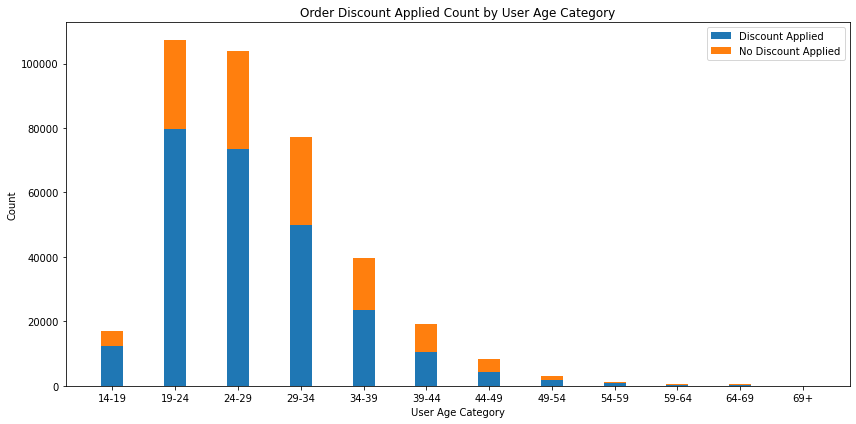

In [49]:
# Pivot the data for plotting
df_pivot = dfvcm.pivot(index='user_age_category', columns='order_discount_applied', values='count')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = df_pivot.index
labels = df_pivot.columns
bar1 = ax.bar(index, df_pivot['y'], bar_width, label='Discount Applied')
bar2 = ax.bar(index, df_pivot['n'], bar_width, bottom=df_pivot['y'], label='No Discount Applied')

# Adding labels, title, and legend
ax.set_xlabel('User Age Category')
ax.set_ylabel('Count')
ax.set_title('Order Discount Applied Count by User Age Category')
ax.set_xticks(index)
ax.set_xticklabels(index)
ax.legend()

# Adding labels on top of bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
# autolabel(bar1)
# autolabel(bar2)

plt.tight_layout()
plt.show()

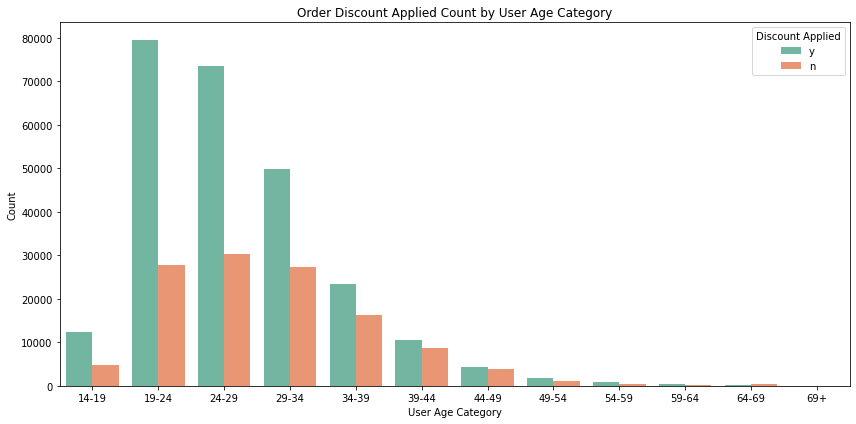

In [50]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='user_age_category', y='count', hue='order_discount_applied', data=dfvcm, palette='Set2')

# Adding labels and title
plt.xlabel('User Age Category')
plt.ylabel('Count')
plt.title('Order Discount Applied Count by User Age Category')
plt.legend(title='Discount Applied', loc='upper right')

plt.tight_layout()
plt.show()

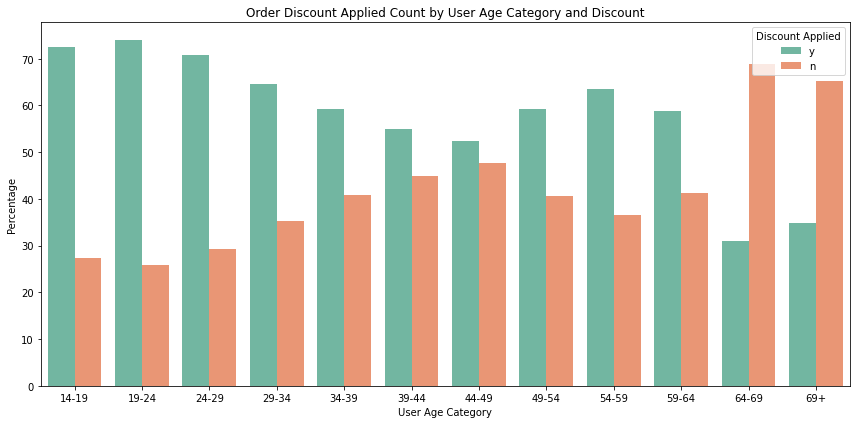

In [51]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='user_age_category', y='percentage', hue='order_discount_applied', data=dfvcm, palette='Set2')

# Adding labels and title
plt.xlabel('User Age Category')
plt.ylabel('Percentage')
plt.title('Order Discount Applied Count by User Age Category and Discount')
plt.legend(title='Discount Applied', loc='upper right')

plt.tight_layout()
plt.show()

In [52]:
print(len(df_oct.transaction_id.unique()))
print(len(df_nov.transaction_id.unique()))
print(len(df_dec.transaction_id.unique()))

139015
127026
128079


In [53]:
print(len(df_oct.order_discount_code.unique()))
print(len(df_nov.order_discount_code.unique()))
print(len(df_dec.order_discount_code.unique()))

643
532
531


In [54]:
dfp = df

In [55]:
for i, age in enumerate(dfp['user_age']):
    try:
        float(age)
    except ValueError:
        dfp = dfp.drop(i)
        print('-', end=' ')

dfp.user_age = dfp.user_age.astype('float')

In [56]:
# ['mid', 'sender_id', 'year', 'month', 'day', 'order_promotion_discount', 'order_coupon_discount', 'order_seller_discount', 'order_delivery_discount', 'order_status' 'order_delivery_discount', 'delivery_address_postal_code', 'restaurant_address_postal_code', 'user_dob', 'user_address_postal_code', 'user_address_country']

In [57]:
bin_size = 5

# Get min and max age from DataFrame
min_age = int(dfp.user_age.min())
max_age = int(dfp.user_age.max())

# Calculate number of bins based on min and max age, with a bin size of 5
num_bins = ((max_age - min_age) // bin_size) + 1

# Create bins and labels lists
bins = [min_age + 5 * i for i in range(num_bins)]
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)] + [f'{bins[-1]}+']

bins = bins + [bins[-1] + bin_size]

print("Bins:", bins)
print("Labels:", labels)

Bins: [14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74]
Labels: ['14-19', '19-24', '24-29', '29-34', '34-39', '39-44', '44-49', '49-54', '54-59', '59-64', '64-69', '69+']


In [58]:
# dfp

In [59]:
dfp["user_age_category"] = pd.cut(dfp['user_age'].values.tolist(), bins=bins, labels=labels)
dfp[['user_age', 'user_age_category']]


,user_age,user_age_category
0,23.0,19-24
1,23.0,19-24
2,28.0,24-29
3,28.0,24-29
4,28.0,24-29
...,...,...
741079,28.0,24-29
741080,28.0,24-29
741081,28.0,24-29
741082,22.0,19-24


In [60]:
dfp.groupby('user_age_category').mean()

,product_quantity,product_total,order_subtotal,order_convenience_fee,order_packaging_fee,order_delivery_fee,order_tip,order_taxes,order_membership_fee,order_discount,order_membership_discount,order_amount_paid,user_age
user_age_category,,,,,,,,,,,,,
14-19,1.368473,202.404335,382.684398,4.278723,22.682190,36.967376,17.538298,17.903520,13.666983,108.939538,39.489957,378.415272,17.985557
19-24,1.300368,207.946301,392.992913,4.229514,21.985329,37.778091,26.676586,18.458093,20.345581,110.138290,52.984504,371.197181,22.489328
24-29,1.293722,212.180153,413.358792,4.091288,21.748662,40.030682,22.771163,19.873596,47.049349,109.827245,53.985546,396.673898,26.938428
29-34,1.341886,214.218657,441.441135,3.942015,21.929176,39.807050,27.171554,21.691516,59.785551,111.837678,59.610182,429.534928,31.884046
34-39,1.392818,217.518770,472.019962,3.901725,22.902406,41.048897,23.409418,23.829967,66.935772,112.033354,59.003044,486.439527,36.713232
39-44,1.412803,229.884550,534.120997,4.074101,24.568642,41.215492,24.474979,27.264773,81.313725,114.573756,73.903097,528.410081,41.754025
44-49,1.442574,245.126835,591.496388,3.686566,26.861682,48.928717,33.203175,30.280881,74.714286,123.374827,52.089819,597.298475,46.538248
49-54,1.415294,250.987017,589.509349,3.584567,25.518976,42.336772,23.906250,30.376083,21.920000,117.098056,66.662746,570.991958,51.904820
54-59,1.387737,227.271912,452.726144,3.141025,23.754493,39.110016,22.619048,22.306628,118.000000,113.264184,57.206866,492.503380,57.192691


In [61]:
dfp.user_gender.value_counts()

male      546912
female    160422
other       4358
Name: user_gender, dtype: int64

In [62]:
kk = dfp[dfp.user_gender.isin(['female', 'male'])].groupby(['user_age_category', 'user_gender']).mean().reset_index()

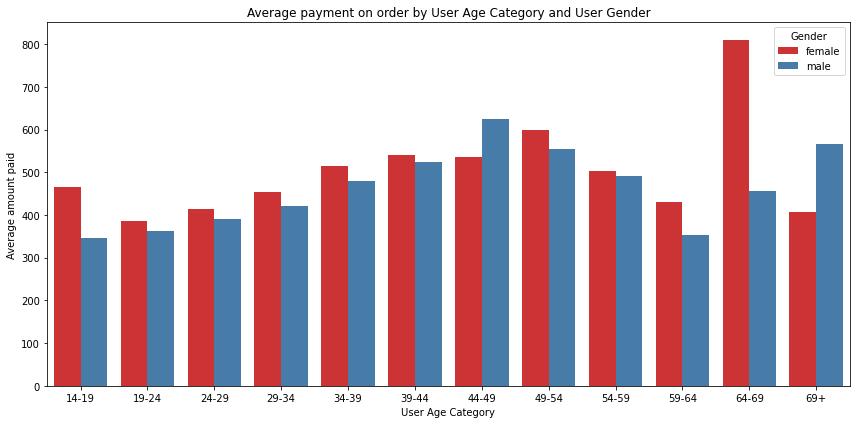

In [63]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='user_age_category', y='order_amount_paid', hue='user_gender', data=kk, palette='Set1')

# Adding labels and title
plt.xlabel('User Age Category')
plt.ylabel('Average amount paid')
plt.title('Average payment on order by User Age Category and User Gender')
plt.legend(title='Gender', loc='upper right')

plt.tight_layout()
plt.show()

In [64]:
df_female, df_male = df[df.user_gender == 'female'], df[df.user_gender == 'male']

In [65]:
len(df_male.transaction_id.unique())

294308

In [66]:
len(df_male.user_id.unique())

36516

In [67]:
len(df_male.transaction_id.unique()) / len(df_male.user_id.unique())

8.05969985759667

In [68]:
len(df_female.transaction_id.unique())

81978

In [69]:
len(df_female.user_id.unique())

9269

In [70]:
len(df_female.transaction_id.unique()) / len(df_female.user_id.unique())

8.844319775596073

In [71]:
type(dfp[(dfp.company == 'swiggy') & (dfp.order_discount_code.isna())]['order_discount_code'][11]) == float

True

In [72]:
dfp['order_discount_code'].value_counts(dropna=False).head(100)

NaN               474141
SWIGGYIT           71249
TRYNEW             44300
MISSEDYOU          19710
WORLDCUPMANIA      13902
FLATDEAL           12279
STEALDEAL           9592
PARTY               9111
FLAT125             7480
SWIGGYWEEKENDS      7212
SUPERSAVER          4861
MDM150              4666
DEALICIOUS          4443
JUMBO               3421
WELCOMEBACK         3282
SPECIALS            3203
MEGASAVER           3095
FLAT100             2837
BOGO                2697
CELEBRATIONS        2527
FREEDISH            2486
HAPPYDIWALI         2418
WELCOME50           2004
AXIS120             1997
SMASH               1993
SAVERDEAL           1972
MATCHMANIA          1677
LUNCHBINGE          1624
WELCOMEBACK100      1114
SAVEBIG             1095
DNBINGE             1077
FLAT150              975
BFBINGE              938
GIFT100OFF           892
STEALDEAL150         827
SAVINGS4ONE          610
AXIS200              605
DURGAPUJA            553
WORLDCUP             479
SNACKSBINGE          471
